In [137]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation,digits
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import word2vecReader as godin_embedding
from gensim.models import KeyedVectors
from sklearn.model_selection import StratifiedKFold
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [138]:
seed = 7
np.random.seed(seed)

In [139]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [140]:
master_dict = load_data_from_json('dataset/master_train.json')

In [141]:
def extract_data_from_dict(master_dict):
    sentence = []
    aspect = []
    for key in master_dict.keys():
        for info in master_dict[key]['info']:
            sentence.append(eval(info['snippets'])[0])
            aspect.append(eval(info['aspects'])[0])
    return sentence,aspect

In [142]:
sentence,aspect = extract_data_from_dict(master_dict)

In [143]:
len(sentence),len(aspect)

(1171, 1171)

In [144]:
aspect_level1= []
aspect_level2=[]
for asp in aspect:
    try:
        aspect_level1.append(asp.split('/')[0])
        aspect_level2.append(asp.split('/')[1])
    except:
        print(asp)

In [145]:
n_label_level_1 = len(set(aspect_level1))
n_label_level_2 = len(set(aspect_level2))
n_label_level_1,n_label_level_2

(4, 27)

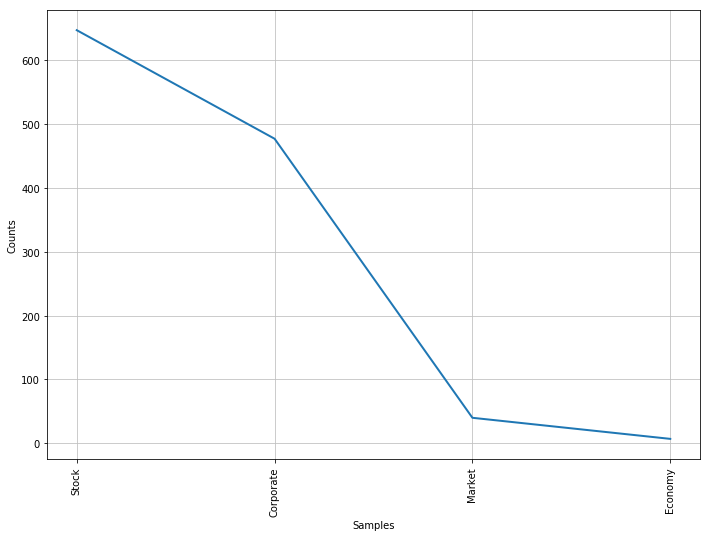

FreqDist({'Stock': 647, 'Corporate': 477, 'Market': 40, 'Economy': 7})


In [146]:
level1_freq = FreqDist(aspect_level1)
level1_freq.plot()
level1_freq.pprint()

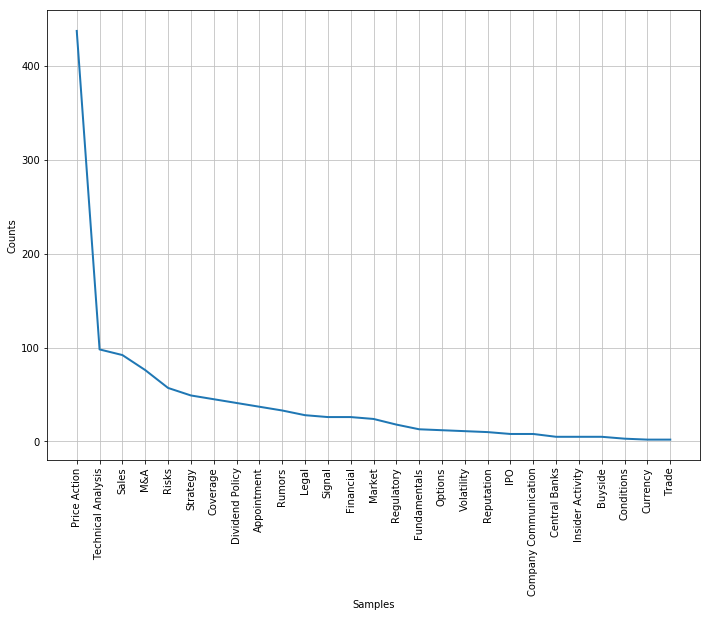

FreqDist({'Price Action': 437, 'Technical Analysis': 98, 'Sales': 92, 'M&A': 76, 'Risks': 57, 'Strategy': 49, 'Coverage': 45, 'Dividend Policy': 41, 'Appointment': 37, 'Rumors': 33, 'Legal': 28, 'Signal': 26, 'Financial': 26, 'Market': 24, 'Regulatory': 18, 'Fundamentals': 13, 'Options': 12, 'Volatility': 11, 'Reputation': 10, 'IPO': 8, 'Company Communication': 8, 'Central Banks': 5, 'Insider Activity': 5, 'Buyside': 5, 'Conditions': 3, 'Currency': 2, 'Trade': 2})


In [147]:
level2_freq = FreqDist(aspect_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [148]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [149]:
L2_L1_pair = get_level_pairs(aspect_level1,aspect_level2)
L1_L2_pair = get_level_pairs(aspect_level2,aspect_level1)

In [150]:
L1_L2_pair

{'Corporate': ['Company Communication',
  'Dividend Policy',
  'Regulatory',
  'Reputation',
  'Financial',
  'Strategy',
  'Technical Analysis',
  'Rumors',
  'Legal',
  'Appointment',
  'M&A',
  'Risks',
  'Sales'],
 'Economy': ['Central Banks', 'Trade'],
 'Market': ['Volatility', 'Market', 'Conditions', 'Currency'],
 'Stock': ['Signal',
  'Technical Analysis',
  'Insider Activity',
  'IPO',
  'Coverage',
  'Fundamentals',
  'Options',
  'Buyside',
  'Price Action']}

In [151]:
L2_L1_pair

{'Appointment': ['Corporate'],
 'Buyside': ['Stock'],
 'Central Banks': ['Economy'],
 'Company Communication': ['Corporate'],
 'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Currency': ['Market'],
 'Dividend Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'IPO': ['Stock'],
 'Insider Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Options': ['Stock'],
 'Price Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Stock', 'Corporate'],
 'Trade': ['Economy'],
 'Volatility': ['Market']}

In [152]:
with open('models/l2_l1_map.json','w') as f:
    json.dump(L2_L1_pair,f,indent=4)

In [153]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,' ')
    return s

In [154]:
def clean_sentence(sentence):
    sentence = sentence.lower()
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
#     print(sentence)
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
#     print(sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
#     print(sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
#     print(sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    sentence = sentence.replace("'s",'')
    sentence = sentence.replace("-",' ')
#     print(sentence)
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    tokens = [remove_punctuation(w) for w in tokens]
#     print(tokens)
    #     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
#     for w in stop_words:
#         print(w)
#     print(tokens)
    # filter out short tokens
#     tokens = [word for word in tokens if len(word) > 1]
#     print(tokens)
    remove_digits = str.maketrans('', '', digits)
#     print(tokens)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
#     print(tokens)
    tokens = ' '.join(tokens)
    return tokens

In [155]:
sentence = [clean_sentence(x) for x in sentence]

In [156]:
lengths = [len(s.split()) for s in sentence]

max len =  11


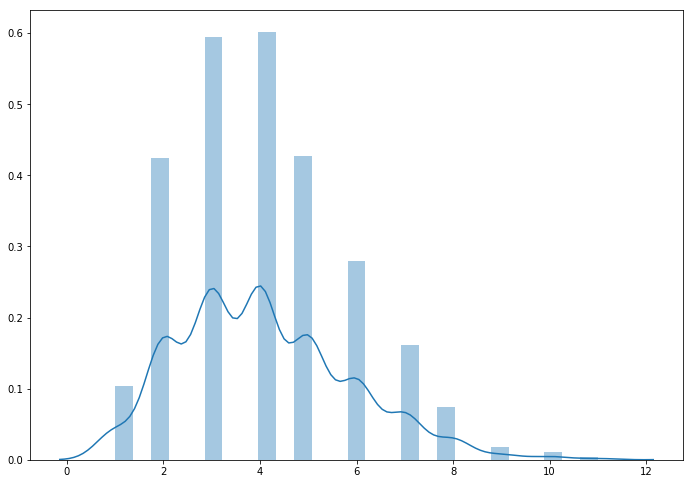

In [157]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [158]:
max_length  = max(lengths)

In [159]:
dataX = sentence
dataY = aspect_level2

In [160]:
no_of_classes = n_label_level_2
no_of_classes

27

In [161]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [162]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [163]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY+testY)
    temp1 = le.transform(trainY)
    return to_categorical(temp1,no_of_classes),le.classes_

In [164]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [165]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [166]:
# embeddings_index_glove = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')

In [123]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [124]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [125]:
# fast_text_model = load_fast_text_model(sentence)

In [126]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [127]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [128]:
# godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

In [129]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [130]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [131]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

In [167]:
def define_model(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,free_em_dim):
    model = Sequential()
    
    if em == 'free':
        model.add(Embedding(vocab_size, free_em_dim))
    else:
        model.add(Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = em_trainable_flag))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=dropout)))
    for i in range(n_hidden_layer):
        model.add(Dense(int((2*lstm_out+no_of_classes)/2),activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    print(model.summary())
    return model

In [168]:
tokenizer = create_tokenizer(dataX)
vocab_size = len(tokenizer.word_index) + 1
trainX = encode_text(tokenizer, dataX, max_length)
# testX = encode_text(tokenizer, testX, max_length)
trainY,lable_encoding = convert_lables(dataY,[])

In [169]:
with open('models/label_encoding.json','w') as f:
            json.dump({'lables_index':list(lable_encoding)},f)

In [172]:
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [173]:
model = define_model(learning_rate=0.0006296220146941253,
                     dropout=0.5,
                     lstm_out=400,
                     n_hidden_layer=1,
                     em='embedding_matrix_word2vec',
                     em_trainable_flag=False,
                     free_em_dim=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 11, 300)           577200    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_7 (Dense)              (None, 413)               330813    
_________________________________________________________________
dense_8 (Dense)              (None, 27)                11178     
Total params: 3,162,391
Trainable params: 2,585,191
Non-trainable params: 577,200
_________________________________________________________________
None


In [174]:
history_object = model.fit(trainX, trainY, epochs=100,batch_size=8)

Epoch 1/100
1171/1171 [==============================] - 20s 17ms/step - loss: 2.0841 - acc: 0.4697
Epoch 2/100
1171/1171 [==============================] - 18s 16ms/step - loss: 1.2610 - acc: 0.6507
Epoch 3/100
1171/1171 [==============================] - 18s 16ms/step - loss: 0.9446 - acc: 0.7430
Epoch 4/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.7251 - acc: 0.7959
Epoch 5/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.5746 - acc: 0.8292
Epoch 6/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.4707 - acc: 0.8488
Epoch 7/100
1171/1171 [==============================] - 20s 17ms/step - loss: 0.3543 - acc: 0.8933
Epoch 8/100
1171/1171 [==============================] - 21s 18ms/step - loss: 0.2865 - acc: 0.9146
Epoch 9/100
1171/1171 [==============================] - 23s 20ms/step - loss: 0.2607 - acc: 0.9257
Epoch 10/100
1171/1171 [==============================] - 22s 19ms/step - loss: 0.2236 - acc: 0.9249

1171/1171 [==============================] - 19s 16ms/step - loss: 0.0227 - acc: 0.9915
Epoch 83/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0587 - acc: 0.9846
Epoch 84/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0170 - acc: 0.9915
Epoch 85/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0322 - acc: 0.9880
Epoch 86/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0300 - acc: 0.9880
Epoch 87/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0254 - acc: 0.9906
Epoch 88/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0140 - acc: 0.9923
Epoch 89/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0160 - acc: 0.9923
Epoch 90/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0140 - acc: 0.9915
Epoch 91/100
1171/1171 [==============================] - 19s 16ms/step - loss: 0.0137 - acc: 0.9923
Epo

In [175]:
model.save('models/aspect_model.h5')

## K-fold Validation

In [ ]:
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
# dataX = np.asarray(dataX)
# dataY = np.asarray(dataY)

In [ ]:
# cv_f1_w = []
# cv_f1_m = []

In [87]:
# first_iteration_flag = True
# for train,test in kfold.split(dataX,dataY):
#     trainX = list(dataX[train])
#     trainY = list(dataY[train])
#     testX = list(dataX[test])
#     testY = list(dataY[test])
#     tokenizer = create_tokenizer(trainX)
#     vocab_size = len(tokenizer.word_index) + 1
#     trainX = encode_text(tokenizer, trainX, max_length)
#     testX = encode_text(tokenizer, testX, max_length)
#     trainY,lable_encoding = convert_lables(trainY,testY)
#     if first_iteration_flag:
#         with open('models/label_encoding.json','w') as f:
#             json.dump({'lables_index':list(lable_encoding)},f)
#         first_iteration_flag = False
#     embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)
#     model = define_model(learning_rate=0.0006296220146941253,
#                          dropout=0.5,
#                          lstm_out=400,
#                          n_hidden_layer=1,
#                          em='embedding_matrix_word2vec',
#                          em_trainable_flag=False,
#                          free_em_dim=400)
#     history_object = model.fit(trainX, trainY, epochs=100,batch_size=8)
#     pred = model.predict(testX)
#     pred_class = get_class_from_pred(pred)
#     f1_w = f1_score(testY,pred_class,average='weighted')
#     f1_m = f1_score(testY,pred_class,average='macro')
#     print(f1_w,f1_m)
#     cv_f1_w.append(f1_w)
#     cv_f1_m.append(f1_m)